In [71]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("../build/output.csv", sep=';')
array_sizes = {10000: "small", 10000000: "medium", 100000000: "large"}
dataset = dataset.astype({'method': 'category',  'array_size': 'category'})
dataset['array_size'] = dataset['array_size'].replace(array_sizes)
print(dataset.head())


             method array_size  elapsed_time
0            single      small          0.01
1  critical_section      small          0.01
2         reduction      small          0.00
3            single     medium          0.03
4  critical_section     medium          0.02


In [72]:
print(dataset.describe())

       elapsed_time
count    270.000000
mean       0.018926
std        0.012192
min        0.000000
25%        0.010000
50%        0.020000
75%        0.020000
max        0.070000


In [73]:
means_for_single_thread = dataset[dataset['method'] == 'single'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_critical_section = dataset[dataset['method'] == 'critical_section'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_reduction = dataset[dataset['method'] == 'reduction'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')

In [74]:
def visualize(ylabel, title, data):
    labels = array_sizes.keys()
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,10))
    rects1 = ax.bar(x - 3*width/2, data['single'], width, label='Однопоточная версия')
    rects2 = ax.bar(x - width/2, data['critical_section'], width, label='Многопоточная с критической секцией')
    rects3 = ax.bar(x + width/2, data['reduction'], width, label='Многопоточная с редукцией')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Размер массива')
    ax.set_xticks(x, labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()

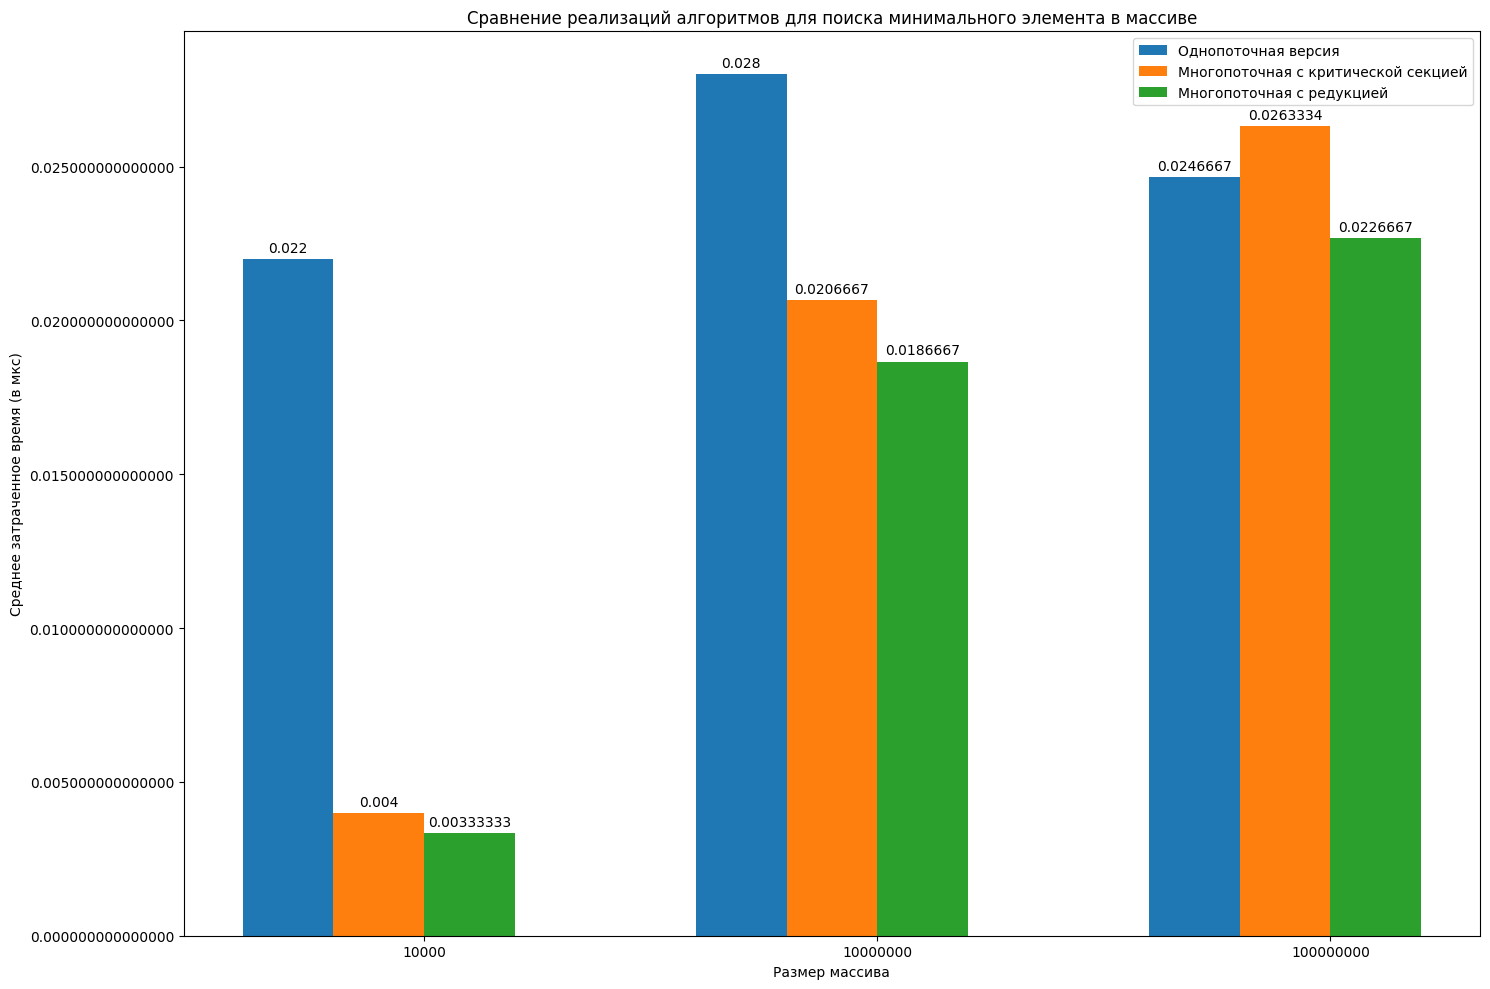

In [75]:
mean_data = dict(zip(dataset['method'].unique(), [
                means_for_single_thread['elapsed_time'], means_for_critical_section['elapsed_time'], means_for_reduction['elapsed_time']]))
visualize('Среднее затраченное время (в мкс)', 'Сравнение реализаций алгоритмов для поиска минимального элемента в массиве', mean_data)
